In [4]:
import os
os.chdir('/home/invisibleman/Robotics/adaptive-coverage-with-voronoi')

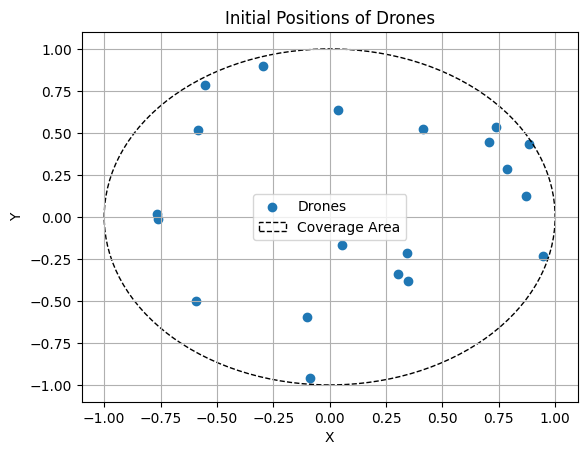

TypeError: only integer scalar arrays can be converted to a scalar index

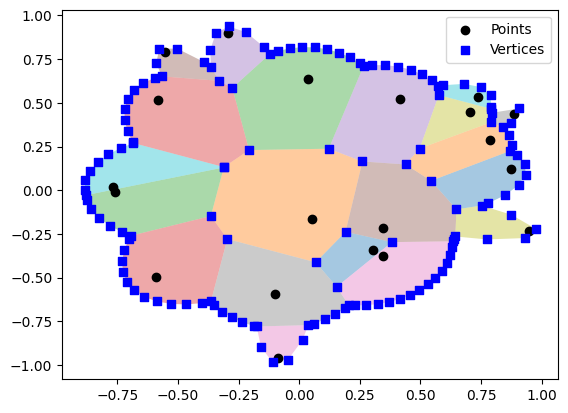

In [8]:
from initialization import initial_setup
from sensor import sensor_func
from dintegrate import integrate_sensor_values
from utils import voronoi
import numpy as np

# Number of drones
n = 20

# Radius of the circular area to be covered
r = 1

vor, finite_vertices, finite_regions, voronoi_centers, grid_points, weed_density = initial_setup(n, r)

In [2]:
def test_integrate_sensor_values(vor, finite_vertices, finite_regions, voronoi_centers, time_step=0.05, time_limit=5):
    """
    Test the function integrate_sensor_values.
    """
    # Define a simple sensor function that ignores time and returns the sum of coordinates
    # def sensor_func(t, point):
    #     return sum(point)

    # Select a random region for testing
    region_index = np.random.randint(len(finite_regions))
    region = finite_regions[region_index]
    partition = finite_vertices[region_index]

    # Calculate Voronoi center
    voronoi_center = voronoi_centers[region_index]

    # Call the function
    mv, lv, cv = integrate_sensor_values(sensor_func, partition, voronoi_center, grid_points, weed_density, time_step, time_limit)
    
    print(f"mv: {mv}, lv: {lv}, cv: {cv}")

In [3]:
def test_integrate_sensor_values_with_neighbours(vor, finite_vertices, finite_regions, voronoi_centers, 
                                                    time_step=0.05, time_limit=5, distance_threshold=0.5):
    """
    Test the function integrate_sensor_values by performing integration for each Voronoi center and its neighbours.
    
    Parameters:
    vor (scipy.spatial.qhull.Voronoi): Voronoi diagram.
    finite_vertices (list): List of vertices of finite Voronoi regions.
    finite_regions (list): List of finite Voronoi regions.
    voronoi_centers (np.array): Coordinates of Voronoi centers.
    time_step (float): Time step for integration. Default is 0.05.
    time_limit (float): Time limit for integration. Default is 5.
    distance_threshold (float): Threshold distance for determining neighbours. Default is 0.5.

    Returns:
    None
    """

    # Compute Voronoi neighbours for each Voronoi center
    neighbours = voronoi.compute_voronoi_neighbours(voronoi_centers, distance_threshold)

    # For each Voronoi center
    for i, center in enumerate(voronoi_centers):
        print(f"\nProcessing Voronoi center {i}...")

        # Get the corresponding partition
        partition = finite_vertices[i]

        # Integrate sensor values for the center
        mv, lv, cv = integrate_sensor_values(sensor_func, partition, center, grid_points, weed_density, time_step, time_limit)
        print(f"For the center itself, mv: {mv}, lv: {lv}, cv: {cv}")

        # For each neighbour of the current center
        for neighbour_index in neighbours[i]:
            # Get the corresponding partition
            partition = finite_vertices[neighbour_index]

            # Integrate sensor values for the neighbour
            mv, lv, cv = integrate_sensor_values(sensor_func, partition, voronoi_centers[neighbour_index], grid_points, weed_density, time_step, time_limit)
            print(f"For neighbour {neighbour_index}, mv: {mv}, lv: {lv}, cv: {cv}")

In [4]:
test_integrate_sensor_values_with_neighbours(vor, finite_vertices, finite_regions, voronoi_centers, 
                                                    time_step=0.05, time_limit=5, distance_threshold=0.5)


Processing Voronoi center 0...
For the center itself, mv: 0.5272745503206074, lv: 0.43354010938328397, cv: 0.8222283990753421
For neighbour 0, mv: 0.5272745503206074, lv: 0.43354010938328397, cv: 0.8222283990753421
For neighbour 8, mv: 4.98793862566215e-08, lv: 3.155854836099759e-08, cv: 0.6326972067906746
For neighbour 16, mv: 0.09029615813885043, lv: 0.09255121245139152, cv: 1.024973978506078

Processing Voronoi center 1...
For the center itself, mv: 7.3529410784832105, lv: 2.646447118655847, cv: 0.35991681293354866
For neighbour 1, mv: 7.3529410784832105, lv: 2.646447118655847, cv: 0.35991681293354866
For neighbour 6, mv: 9.331573713253814, lv: 2.0401403313249844, cv: 0.2186276821054667
For neighbour 14, mv: 1.4542175251178005e-09, lv: 1.688814800794812e-09, cv: 1.1613219973112396

Processing Voronoi center 2...
For the center itself, mv: 0.0022209279962187743, lv: 0.0006991240823987438, cv: 0.31478917082815505
For neighbour 2, mv: 0.0022209279962187743, lv: 0.0006991240823987438, 

In [5]:
1

1

In [6]:
def optimize_voronoi_centers_consensus(voronoi_centers, finite_vertices, finite_regions, 
                                        grid_points, weed_density, sensor_func, neighbours, 
                                        time_step=0.05, time_limit=5, alpha=0.1, beta=0.1, 
                                        epsilon=1e-6, max_iter=100):
    """
    Optimize Voronoi centers using gradient descent and consensus algorithm.
    
    Parameters:
    voronoi_centers (np.array): Coordinates of Voronoi centers.
    finite_vertices (list): List of vertices of finite Voronoi regions.
    finite_regions (list): List of finite Voronoi regions.
    sensor_func (function): Sensor function.
    neighbours (list): List of lists where each sublist contains the indices of neighbouring Voronoi centers for a given center.
    time_step (float): Time step for integration. Default is 0.05.
    time_limit (float): Time limit for integration. Default is 5.
    alpha (float): Learning rate for gradient descent. Default is 0.1.
    beta (float): Weight for the consensus term. Default is 0.1.
    epsilon (float): Threshold for determining convergence. Default is 1e-6.
    max_iter (int): Maximum number of iterations. Default is 100.

    Returns:
    np.array: Updated coordinates of Voronoi centers.
    """
    for iter in range(max_iter):
        # Initialize change to zero
        change = 0

        # For each Voronoi center
        for i, center in enumerate(voronoi_centers):
            # Get the corresponding partition
            partition = finite_vertices[i]

            # Calculate the moment integrals
            mv, lv, cv = integrate_sensor_values(sensor_func, partition, center, 
                                                grid_points, weed_density, 
                                                time_step, time_limit)

            # Calculate the consensus term
            consensus_term = sum(voronoi_centers[j] - center for j in neighbours[i])

            # Calculate the gradient (negative of the derivative of the cost function, with consensus term)
            gradient = -mv * (cv - center) + beta * consensus_term

            # Update the Voronoi center
            new_center = center - alpha * gradient

            # Calculate the change in position
            change = max(change, np.linalg.norm(new_center - center))

            # Update the Voronoi center
            voronoi_centers[i] = new_center

        # Check for convergence
        if change < epsilon:
            print("Converged after", iter, "iterations.")
            break

    if iter == max_iter - 1:
        print("Reached maximum number of iterations without convergence.")

    return voronoi_centers


In [10]:
optimize_voronoi_centers_consensus(voronoi_centers, finite_vertices, finite_regions, 
                                        grid_points, weed_density, sensor_func, neighbours, 
                                        time_step=0.05, time_limit=5, alpha=0.1, beta=0.1, 
                                        epsilon=1e-6, max_iter=100)

Reached maximum number of iterations without convergence.


array([[ 1.86155601e+01,  1.90053771e+01],
       [ 7.76780387e+11,  7.76780387e+11],
       [-1.13952497e+00, -1.81418216e-01],
       [ 1.03333904e+07,  1.03333904e+07],
       [ 6.88082592e+01,  6.88083055e+01],
       [ 1.12219582e+02,  1.12219584e+02],
       [-3.39910418e+21, -3.39910418e+21],
       [-1.06835928e+22, -1.06835928e+22],
       [-4.88503950e+00, -7.06257794e+00],
       [-7.33503948e+05, -7.33501858e+05],
       [-7.27520699e+05, -7.27521520e+05],
       [-4.15804816e-01,  7.76280070e-01],
       [-9.01629416e+17, -9.01629416e+17],
       [ 2.61231833e+20,  2.61231833e+20],
       [-3.34907004e+10, -3.34907004e+10],
       [ 5.55030866e-01,  4.68241274e-01],
       [ 9.35474188e-01,  7.91483726e-01],
       [ 1.01222662e+24,  1.01222662e+24],
       [-1.77126566e-02,  1.24487697e-01],
       [ 2.65229794e-01,  4.97527534e-01]])

In [8]:
# Compute Voronoi neighbours for each Voronoi center
neighbours = voronoi.compute_voronoi_neighbours(voronoi_centers, distance_threshold)


NameError: name 'distance_threshold' is not defined

In [9]:
    # Compute Voronoi neighbours for each Voronoi center
    neighbours = voronoi.compute_voronoi_neighbours(voronoi_centers, distance_threshold=0.25)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial import Delaunay

def compute_graph_laplacian(points):
    """
    Computes the graph Laplacian from Delaunay triangulation.

    Args:
        points (numpy.ndarray): Array of shape (n, 2) containing the coordinates of the points.

    Returns:
        numpy.ndarray: The graph Laplacian matrix.

    """
    # Perform Delaunay triangulation
    tri = Delaunay(points)

    # Get the edges of the triangulation
    edges = tri.vertices

    # Initialize Laplacian matrix
    n = len(points)
    L = np.zeros((n, n))

    # Compute shared edge lengths as weights
    for r1, r2 in edges:
        points_indices = np.intersect1d(tri.neighbors[r1], tri.neighbors[r2])
        if len(points_indices) == 2:
            edge_len = np.linalg.norm(points[points_indices[1]] - points[points_indices[0]])
        else:
            edge_len = 0
        L[r1, r2] = -edge_len
        L[r2, r1] = -edge_len

    # Compute diagonal elements
    L = L + np.diag(-np.sum(L, axis=1))

    return L

# Generate random points
n = 50
points = np.random.rand(n, 2)

# Compute graph Laplacian
L = compute_graph_laplacian(points)

# Create figure and axes for animation
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-')

def update(frame):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(L)
    sorted_indices = np.argsort(eigenvalues)
    x = np.arange(n)
    y = eigenvectors[:, sorted_indices[frame]]

    # Update the plot
    line.set_data(x, y)
    ax.set_xlim(0, n-1)
    ax.set_ylim(np.min(y), np.max(y))
    ax.set_xlabel('Node')
    ax.set_ylabel('Eigenvector')
    ax.set_title(f'Graph Laplacian Eigenvector {frame+1}/{n}')

    return line,

# Animate the plot
animation = FuncAnimation(fig, update, frames=n, interval=200, blit=True)

# Display the animation
plt.show()


<ipython-input-11-58380e039791>:47: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  L = compute_graph_laplacian(points)


ValueError: too many values to unpack (expected 2)